<a href="https://colab.research.google.com/github/ZahraFarahzadii/PV-fault-detection-semigan/blob/main/fault_detection_semigan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.random import randint
import numpy as np
import os

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
from keras.datasets.mnist import load_data
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random.mtrand import shuffle

from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint
import tensorflow as tf
import keras
import pandas as pd
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt

from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation,ReLU


from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


create train data

In [ ]:
training_data=[]
def create_training_data():
  DATADIR='/content/drive/MyDrive/data4class/train'
  CATEGORIES=['class0','class1','class2','class3']
  for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    class_num=CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        # image_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        # new_array=cv2.resize(image_rgb,(384,384))
        new_array=cv2.resize(img_array,(384,384))
        training_data.append([new_array,class_num])
      except Exception as e:
        pass
create_training_data()


In [ ]:
import random
rnd_seed=42
random.seed(rnd_seed)
random.shuffle(training_data)


In [ ]:
xtrain=[]
ytrain=[]
for features, label in training_data:
  xtrain.append(features)
  ytrain.append(label)
xtrain=np.array(xtrain).reshape(-1,384,384,3)
ytrain=np.array(ytrain)

create test data

In [ ]:
test_data=[]
def create_test_data():
  DATADIR='/content/drive/MyDrive/data4class/valid'
  CATEGORIES=['class0','class1','class2','class3']
  for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    class_num=CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        # image_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        # new_array=cv2.resize(image_rgb,(384,384))
        new_array=cv2.resize(img_array,(384,384))
        test_data.append([new_array,class_num])
      except Exception as e:
        pass
create_test_data()

In [ ]:
import random
rnd_seed=42
random.seed(rnd_seed)
random.shuffle(test_data)

In [ ]:
xtest=[]
ytest=[]
for features, label in test_data:
  xtest.append(features)
  ytest.append(label)
xtest=np.array(xtest).reshape(-1,384,384,3)
ytest=np.array(ytest)


semi supervised gan

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):

	in_lat = Input(shape=(latent_dim,))
	#Start with enough dense nodes to be reshaped and ConvTransposed to 384x384x3
	n_nodes = 256 * 96 * 96
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((96, 96, 256))(X)

	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #192x192x128
	X = LeakyReLU(alpha=0.2)(X)

	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #192x192x64
	X = LeakyReLU(alpha=0.2)(X)
	# output
	out_layer = Conv2DTranspose(3, (3,3), strides=(2,2), activation='tanh',
                             padding='same')(X) #384x384x3
# define model
	model = Model(in_lat, out_layer)
	return model

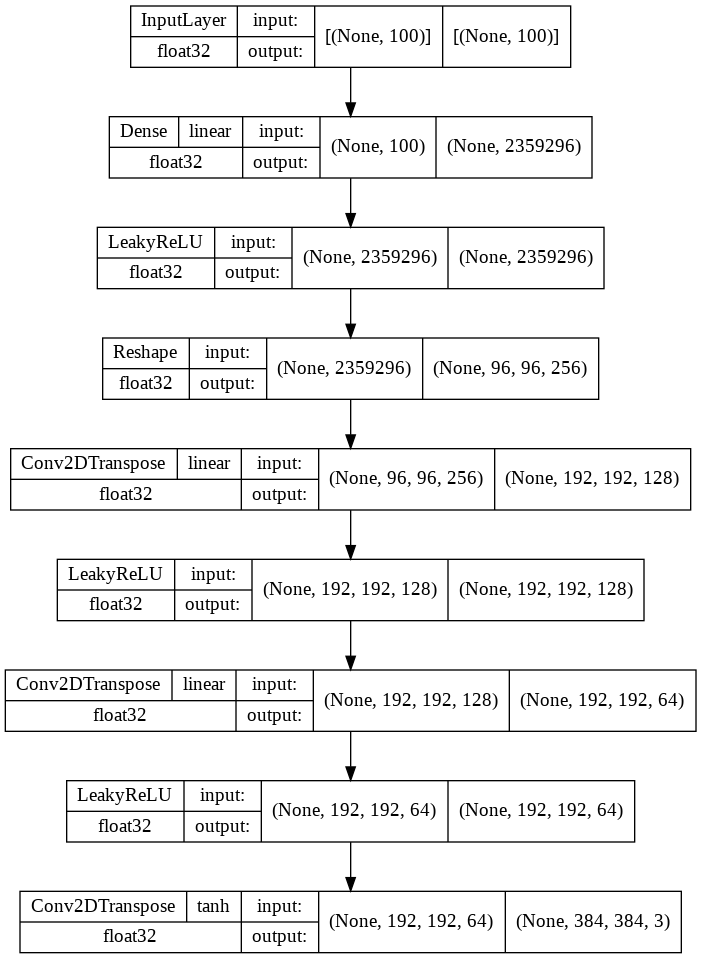

In [ ]:
gen_model=define_generator(100)
from tensorflow.keras.utils import plot_model
plot_model(gen_model,to_file='model_plot.png',show_shapes=True,
           show_dtype=True, show_layer_names=False,rankdir='TB',
           expand_nested=False,dpi=96,layer_range=None,show_layer_activations=True)

In [ ]:

# define the base discriminator model for sup and unsup discriminators
#This is the base discriminator that supervised and unsupervised are going to share weights from.
def define_discriminator(in_shape=(384,384,3), n_classes=4):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting
    X = Dense(n_classes)(X)
    model = Model(inputs=in_image, outputs=X)
    return model

In [ ]:
#Define the supervised discriminator.
#Multiclass classification, so we will use softmax activation.
#To avoid converting our labels to categorical, we will work with sparse categorical crossentropy loss.
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    # sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

In [ ]:
#Define the unsupervised discriminator
#Takes the output of the supervised, just before the softmax activation.
#Then, adds a layer with calculation of sum of exponential outputs.

#This custom activation layer gives a value close to 0 for smaller activations
#in the prior discriminator layer. It gives values close to 1 for large activations.
#This way it gives low activation for fake images. No need for sigmoid anymore.

# custom activation function for the unsupervised discriminator
#D(x) = Z(x) / (Z(x) + 1) where Z(x) = sum(exp(l(x))). l(x) is the output from sup discr. prior to softmax
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)

    return D_x

In [ ]:

def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

In [ ]:
disc=define_discriminator()
disc_sup=define_sup_discriminator(disc)
disc_unsup=define_unsup_discriminator(disc)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


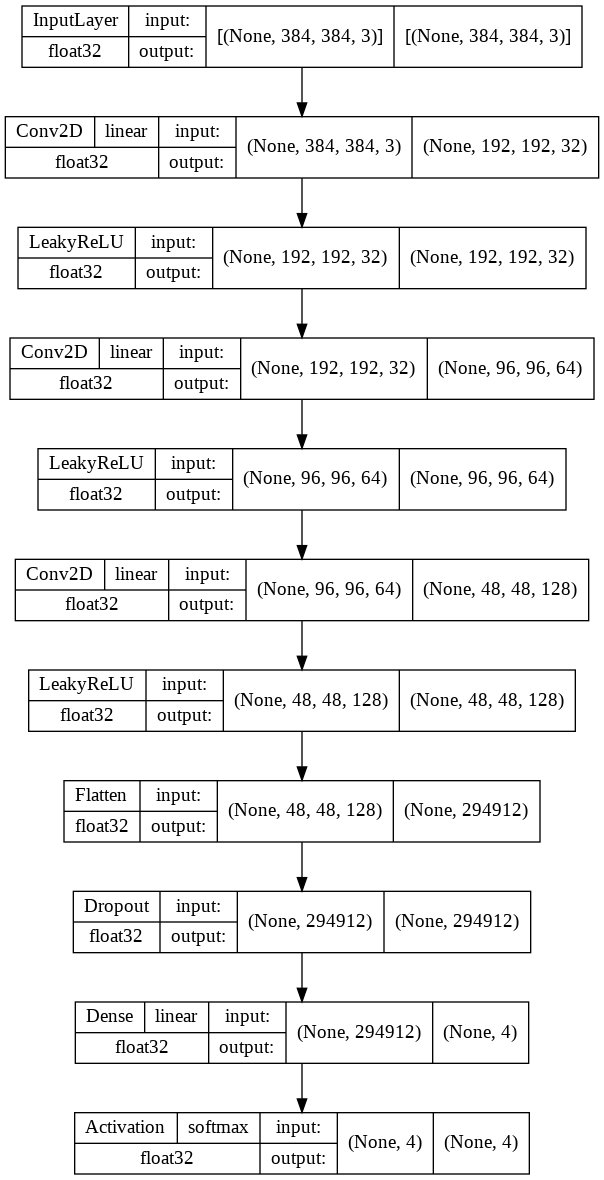

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(disc,to_file='model_plot.png',show_shapes=True,
           show_dtype=True, show_layer_names=False,rankdir='TB',
           expand_nested=False,dpi=96,layer_range=None,show_layer_activations=True)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(gen_model, disc_unsup):

	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [ ]:
# gan_model = define_gan(gen_model, disc_unsup)
# print(gan_model.summary())

In [ ]:
# load the images
def load_real_samples(n_classes=4):
    trainX=xtrain
    trainy=ytrain
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation in generator .
    print(X.shape, trainy.shape)
    return [X, trainy]

In [ ]:
#data = load_real_samples()

#select subset of the dataset for supervised training
# pick only 100 samples to be used in supervised training.
#Also, we need to ensure we pick 10 samples per class to ensure a good balance
def select_supervised_samples(dataset, n_samples=100, n_classes=4):
 	X, y = dataset
 	X_list, y_list = list(), list()
 	n_per_class = int(n_samples / n_classes) #Number of amples per class.
 	for i in range(n_classes):
         X_with_class = X[y == i] # get all images for this class
         ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
         [X_list.append(X_with_class[j]) for j in ix] # add to list
         [y_list.append(i) for j in ix]
 	return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

In [ ]:
# Pick real samples from the dataset.
#Return both images and corresponding labels in addition to y=1 indicating that the images are real.
# we will not use the labels for unsupervised, only used for supervised.
def generate_real_samples(dataset, n_samples):

	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training)
	return [X, labels], y

In [ ]:
# generate latent points, to be used as inputs to the generator.
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [ ]:
# Generate fake images using the generator and above latent points as input to it.
def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training)
	return fake_images, y

In [ ]:
# report accuracy and save plots & the model periodically.
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	# evaluate the discriminator

	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:
# train the generator and discriminator
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=60):

    # select supervised dataset for training.
    #Remember that we are not using all 60k images, just a subset (100 images, 10 per class. )
	X_sup, y_sup = select_supervised_samples(dataset)
	#print(X_sup.shape, y_sup.shape)

	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs

	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs,
                                                              n_batch, half_batch,
                                                              bat_per_epo, n_steps))
	 #  enumerate epochs
	for i in range(n_steps):
				# update supervised discriminator (disc_sup) on real samples.
        # we use real labels to train as this is supervised.
			[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
			sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)
					# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
					# we will not train on labels as this is unsupervised, just binary as in our regular GAN.
					#The y_real below indicates 1s telling the discriminator that these images are real.
			[X_real, _], y_real = generate_real_samples(dataset, half_batch)
			d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
					#Now train on fake.
			X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
			d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)
					# update generator (gen) - like we do in regular GAN.
			X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
			gan_loss = gan_model.train_on_batch(X_gan, y_gan)

			# summarize loss on this batch
			print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
			# evaluate the model performance periodically
			if (i+1) % (bat_per_epo * 1) == 0:
				summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

In [ ]:
# TRAIN
latent_dim = 100

# create the discriminator models
disc=define_discriminator()
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model.

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)

# train the model

train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=60)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(1384, 384, 384, 3) (1384,)
n_epochs=20, n_batch=60, 1/2=30, b/e=23, steps=460
>1, c[1.393,17], d[0.152,1.620], g[0.223]
>2, c[2.180,27], d[0.007,1.602], g[0.229]
>3, c[2.500,33], d[0.004,1.563], g[0.246]
>4, c[1.876,27], d[0.002,1.479], g[0.284]
>5, c[1.515,30], d[0.001,1.320], g[0.367]
>6, c[1.616,27], d[0.001,1.074], g[0.538]
>7, c[1.346,50], d[0.001,0.774], g[0.843]
>8, c[1.346,30], d[0.001,0.468], g[1.343]
>9, c[1.339,33], d[0.001,0.238], g[1.971]
>10, c[1.273,47], d[0.002,0.107], g[2.700]
>11, c[1.306,30], d[0.000,0.069], g[3.069]
>12, c[1.272,27], d[0.000,0.056], g[3.297]
>13, c[1.345,33], d[0.000,0.032], g[3.802]
>14, c[1.533,17], d[0.001,0.030], g[4.195]
>15, c[1.193,57], d[0.000,0.020], g[4.510]
>16, c[1.226,40], d[0.002,0.011], g[5.053]
>17, c[1.380,57], d[0.000,0.006], g[5.390]
>18, c[1.452,47], d[0.000,0.006], g[5.514]
>19, c[1.244,47], d[0.000,0.007], g[5.438]
>20, c[1.301,43], d[0.000,0.006], g[5.651]
>21, c[1.290,40], d[0.001,0.004], g[5.978]
>22, c[1.437,40], d[0.001,0

In [ ]:
#EVALUATE THE SUPERVISED DISCRIMINATOR ON TEST DATA
# This is the model we want as a classifier.

from keras.models import load_model
# load the model
disc_sup_trained_model = load_model('disc_sup_0391.h5')

# load the dataset
testX=xtest
testy = ytest


testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

Test Accuracy: 59.884%


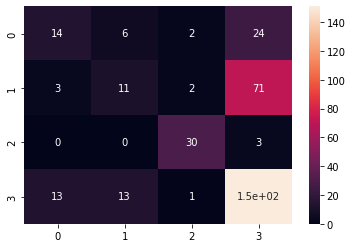

In [ ]:
# evaluate the model
_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)


In [ ]:
#PREDICT / GENERATE IMAGES using the generator, just for fun.
##################################################################

# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()
gen_trained_model = load_model('gen_model_0092.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = gen_trained_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 2)
